In [1]:
# import sys
# !{sys.executable} -m pip install spotipy

In [1]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import warnings
import math
import time
warnings.simplefilter("ignore")

In [2]:
sp = spotipy.Spotify()

USER_ID = "emilyrlandman"
TOP10_PLAYLIST_ID = "1ggWDL88pSeijtf7zifvF1"
ALBUMS_PLAYLIST_ID = "5YVVRDq8QLSB2wJ2lvq3Dx"
CLIENT_ID = "27a2df6fdb064b40b952dbe55f451421" 
CLIENT_SECRET = "a97bf4bf619b4239961eb80513e2c0e0" 
CLIENT_CREDENTIALS = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET) 

sp = spotipy.Spotify(client_credentials_manager=CLIENT_CREDENTIALS) 
sp.trace=False

### Label Encoder

In [41]:
# First we have to gather the total number of tracks in the playlist 
track_count = sp.user_playlist_tracks(USER_ID, TOP10_PLAYLIST_ID, 'total')['total']

# Then we calculate the number of times we'll have to call the API
iterations = math.ceil(track_count/100)

# Finally we begin our loop
attributes_df = pd.DataFrame()
information_df = pd.DataFrame()
for i in range(iterations):
    print(f"Compiling songs {(i)*100+1} through {(i+1)*100} of {track_count}")
    playlist = sp.user_playlist_tracks(USER_ID, TOP10_PLAYLIST_ID, None, None, i*100) # documentation - https://spotipy.readthedocs.io/en/2.13.0/
    songs = playlist["items"]
#     time.sleep(1) # incase this is necessary on larger playlists

    track_ids = []
    track_names = []
    track_popularities = []
    track_explicit = []
    artist_ids = []
    artist_names = []
    artist_popularities = []
    artist_followers = []
    artist_genres = []
    
    for j in range(len(songs)): 
        track_ids.append(songs[j]["track"]["id"])
        track_names.append(songs[j]["track"]["name"])
        track_popularities.append(songs[j]["track"]["popularity"])
        track_explicit.append(songs[j]["track"]["explicit"])
        artist_names.append(songs[j]["track"]["artists"][0]["name"])
        
        artist_id = songs[j]["track"]["artists"][0]["id"]
        artist_ids.append(artist_id)
        artist = sp.artist(artist_id)
        artist_popularities.append(artist['popularity'])
        artist_followers.append(artist['followers']['total'])
        artist_genres.append(artist['genres'])

        
    features = sp.audio_features(track_ids)
    att_df = pd.DataFrame(features)
    info_df = pd.DataFrame({"song_id":track_ids, 
                            "song_name":track_names, 
                            "song_popularity":track_popularities,
                            "explicit":track_explicit,
                            "artist_id":artist_ids, 
                            "artist": artist_names, 
                            "artist popularity": artist_popularities,
                            "artist followers": artist_followers,
                            "genre": artist_genres})
    
    attributes_df = attributes_df.append(att_df, ignore_index=True)
    information_df = information_df.append(info_df, ignore_index=True)

TOP_df = information_df.merge(attributes_df, left_on="song_id", right_on="id")
# TOP_df = TOP_df.drop_duplicates(['song_id'])
# TOP_df.reset_index(inplace=True, drop=True)
TOP_df["top_10"] = 1
print("-"*40,"\nComplete")
# TOP_df

Compiling songs 1 through 100 of 200
Compiling songs 101 through 200 of 200
---------------------------------------- 
Complete


In [42]:
# First we have to gather the total number of tracks in the playlist 
track_count = sp.user_playlist_tracks(USER_ID, ALBUMS_PLAYLIST_ID, 'total')['total']

# Then we calculate the number of times we'll have to call the API
iterations = math.ceil(track_count/100)

# Finally we begin our loop
attributes_df = pd.DataFrame()
information_df = pd.DataFrame()
for i in range(iterations):
    print(f"Compiling songs {(i)*100+1} through {(i+1)*100} of {track_count}")
    playlist = sp.user_playlist_tracks(USER_ID, ALBUMS_PLAYLIST_ID, None, None, i*100) # documentation - https://spotipy.readthedocs.io/en/2.13.0/
    songs = playlist["items"]
#     time.sleep(1) # incase this is necessary on larger playlists

    track_ids = []
    track_names = []
    track_popularities = []
    track_explicit = []
    artist_ids = []
    artist_names = []
    artist_popularities = []
    artist_followers = []
    artist_genres = []
    
    for j in range(len(songs)): 
        track_ids.append(songs[j]["track"]["id"])
        track_names.append(songs[j]["track"]["name"])
        track_popularities.append(songs[j]["track"]["popularity"])
        track_explicit.append(songs[j]["track"]["explicit"])
        artist_names.append(songs[j]["track"]["artists"][0]["name"])
        
        artist_id = songs[j]["track"]["artists"][0]["id"]
        artist_ids.append(artist_id)
        artist = sp.artist(artist_id)
        artist_popularities.append(artist['popularity'])
        artist_followers.append(artist['followers']['total'])
        artist_genres.append(artist['genres'])

        
    features = sp.audio_features(track_ids)
    att_df = pd.DataFrame(features)
    info_df = pd.DataFrame({"song_id":track_ids, 
                            "song_name":track_names, 
                            "song_popularity":track_popularities,
                            "explicit":track_explicit,
                            "artist_id":artist_ids, 
                            "artist": artist_names, 
                            "artist popularity": artist_popularities,
                            "artist followers": artist_followers,
                            "genre": artist_genres})
    
    attributes_df = attributes_df.append(att_df, ignore_index=True)
    information_df = information_df.append(info_df, ignore_index=True)
    
ALBUMS_df = information_df.merge(attributes_df, left_on="song_id", right_on="id")
ALBUMS_df["top_10"] = 0
print("-"*40,"\nComplete")
# ALBUMS_df

Compiling songs 1 through 100 of 2330
Compiling songs 101 through 200 of 2330
Compiling songs 201 through 300 of 2330
Compiling songs 301 through 400 of 2330
Compiling songs 401 through 500 of 2330
Compiling songs 501 through 600 of 2330
Compiling songs 601 through 700 of 2330
Compiling songs 701 through 800 of 2330
Compiling songs 801 through 900 of 2330
Compiling songs 901 through 1000 of 2330
Compiling songs 1001 through 1100 of 2330
Compiling songs 1101 through 1200 of 2330
Compiling songs 1201 through 1300 of 2330
Compiling songs 1301 through 1400 of 2330
Compiling songs 1401 through 1500 of 2330
Compiling songs 1501 through 1600 of 2330
Compiling songs 1601 through 1700 of 2330
Compiling songs 1701 through 1800 of 2330
Compiling songs 1801 through 1900 of 2330
Compiling songs 1901 through 2000 of 2330
Compiling songs 2001 through 2100 of 2330
Compiling songs 2101 through 2200 of 2330
Compiling songs 2201 through 2300 of 2330
Compiling songs 2301 through 2400 of 2330
-------------

In [14]:
FULL_df = TOP_df.append(ALBUMS_df, ignore_index=True)
FULL_df.drop_duplicates(["song_id"], inplace=True)
FULL_df.reset_index(inplace=True, drop=True)
#FULL_df

In [15]:
allGenres = FULL_df["genre"].explode()
# allGenres.value_counts().to_csv("genre_count.csv")
allGenres.value_counts().head(10)

pop                   1455
dance pop             1157
pop rap                605
post-teen pop          578
pop rock               454
rap                    452
urban contemporary     443
r&b                    383
hip pop                301
hip hop                294
Name: genre, dtype: int64

In [16]:
#Adding columns for the most common genres

pop = [0]*len(FULL_df.index)
rap = [0]*len(FULL_df.index)
rnb = [0]*len(FULL_df.index)
edm = [0]*len(FULL_df.index)
rock = [0]*len(FULL_df.index)
latin = [0]*len(FULL_df.index)
hiphop = [0]*len(FULL_df.index)
mellow = [0]*len(FULL_df.index)
country = [0]*len(FULL_df.index)


for i in range(len(FULL_df["genre"])):
    for item in FULL_df["genre"][i]:

        if (("edm" in item) or 
            ("dance" in item) or 
            ("vapor" in item) or 
            ("techno" in item) or 
            ("electro" in item) or 
            ("brostep" in item) or 
            ("complextro" in item))\
        and (("dancehall" not in item) and
             ("dance pop" not in item)):
            edm[i]=1
            
        if (("rock" in item) or 
            ("punk" in item) or
            ("metal" in item) or
            ("indie" in item) or
            ("grunge" in item) or
            ("baroque" in item) or
            ("permanent wave" in item)):
            rock[i]=1

        if ("pop" in item)\
        and (("punk" not in item) and 
             ("rock" not in item) and 
             ("baroque" not in item) and 
             ("dance pop" not in item) and 
             ("indie poptimism" not in item)):
            pop[i]=1
            
        if (("hip" in item) or 
            ("hop" in item) or 
            ("dancehall" in item) or 
            ("new jack swing" in item)):
            hiphop[i]=1
            
        if (("r&b"in item) or
            ("soul"in item) or
            ("motown"in item) or
            ("quiet storm" in item)):
            rnb[i]=1

        if (("rap" in item) or 
            ("urban" in item))\
        and ("vapor" not in item):
            rap[i]=1
            
        if (("country"in item) or
            ("lilith" in item)):
            country[i]=1

        if "mellow" in item:
            mellow[i]=1
            
        if "latin" in item:
            latin[i]=1

# In order of most appearing (done in excel)   
FULL_df["pop"] = pop
FULL_df["rap"] = rap
FULL_df["hiphop"] = hiphop
FULL_df["rock"] = rock
FULL_df["rnb"] = rnb
FULL_df["country"] = country
FULL_df["mellow"] = mellow
FULL_df["edm"] = edm
FULL_df["latin"] = latin

# FULL_df

In [17]:
# Encode Strings in "Artist Column"
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
FULL_df['artist_id'] = encode.fit_transform(FULL_df['artist_id'])
FULL_df.head()

,song_id,song_name,song_popularity,explicit,artist_id,artist,artist popularity,artist followers,genre,danceability,...,top_10,pop,rap,hiphop,rock,rnb,country,mellow,edm,latin
0,3y4LxiYMgDl4RethdzpmNe,Breathe,65,False,34,Faith Hill,67,1135327,"[contemporary country, country, country dawn, ...",0.529,...,1,0,0,0,1,0,1,0,0,0
1,3i3GeK0qLQybu4ah42YmCY,Smooth (feat. Rob Thomas),54,False,142,Santana,74,1616127,"[blues rock, classic rock, mexican classic rock]",0.612,...,1,0,0,0,1,0,0,0,0,0
2,3fucYASejkSMwtAYjFRKlF,Maria Maria (feat. The Product G&B),53,False,142,Santana,74,1616127,"[blues rock, classic rock, mexican classic rock]",0.779,...,1,0,0,0,1,0,0,0,0,0
3,6ctr1K7KzKErxbfGAynL8A,I Wanna Know,57,False,89,Joe,67,1039439,"[dance pop, hip pop, neo soul, new jack swing,...",0.724,...,1,1,1,1,0,1,0,0,0,0
4,4cKGldbhGJniI8BrB3K6tb,Everything You Want,64,False,143,Vertical Horizon,56,280308,"[neo mellow, pop rock, post-grunge]",0.637,...,1,0,0,0,1,0,0,1,0,0


In [128]:
#Set up data

# Assign X (data) and y (target)
X = FULL_df.drop(['song_id', 'song_name',
                  'artist', 'genre', 
                  'type', 'id', 'uri', 'track_href', 'analysis_url',
                  'top_10'], axis=1)
# X = X.drop(['artist popularity', 'artist followers'], axis=1)
# X = X.drop(['song_popularity'], axis=1)

y = FULL_df['top_10']
print(X.shape, y.shape)

# Select random state for Notebook
rs = 42

#Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, stratify=y)

(2330, 27) (2330,)


### Logistic Regression

Training Data Score: 0.6697195191757298
Testing Data Score: 0.6586620926243568

              precision    recall  f1-score   support

    negative       0.91      0.70      0.79       533
    positive       0.07      0.26      0.12        50

    accuracy                           0.66       583
   macro avg       0.49      0.48      0.45       583
weighted avg       0.84      0.66      0.73       583



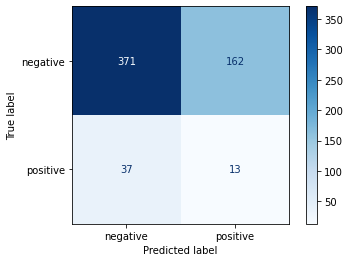

In [129]:
#create model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(class_weight = 'balanced')

#train model
classifier.fit(X_train, y_train)

#test model
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}\n")

# Calculate classification report
target_names = ["negative", "positive"]
from sklearn.metrics import classification_report
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, display_labels=target_names)
plt.show()

### Decision Tree

Training Data Score: 1.0
Testing Data Score: 0.8867924528301887

              precision    recall  f1-score   support

    negative       0.94      0.93      0.94       533
    positive       0.35      0.38      0.37        50

    accuracy                           0.89       583
   macro avg       0.65      0.66      0.65       583
weighted avg       0.89      0.89      0.89       583



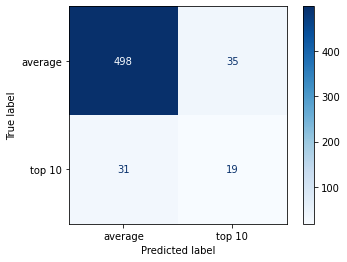

[(0.5153491626164202, 'song_popularity'),
 (0.09122257985411013, 'artist followers'),
 (0.06724635602717172, 'acousticness'),
 (0.044932226026966456, 'liveness'),
 (0.03651394698948307, 'danceability'),
 (0.033657961442147444, 'loudness'),
 (0.03039358211803685, 'valence'),
 (0.028953630638342113, 'energy'),
 (0.025432297296732354, 'instrumentalness'),
 (0.02456259745886361, 'duration_ms'),
 (0.02055367598674002, 'artist popularity'),
 (0.018851967704932755, 'artist_id'),
 (0.016173040799660175, 'speechiness'),
 (0.013765298048556114, 'tempo'),
 (0.010099157598810768, 'key'),
 (0.009946023670664217, 'rap'),
 (0.005850769287708195, 'time_signature'),
 (0.002931118710307703, 'rnb'),
 (0.0012236157846436048, 'latin'),
 (0.0011961722488038047, 'rock'),
 (0.0011448196908986589, 'pop'),
 (0.0, 'mode'),
 (0.0, 'mellow'),
 (0.0, 'hiphop'),
 (0.0, 'explicit'),
 (0.0, 'edm'),
 (0.0, 'country')]

In [130]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight = 'balanced')

#train model
clf = clf.fit(X_train, y_train)

#test model
print(f"Training Data Score: {clf.score(X_train, y_train)}")
print(f"Testing Data Score: {clf.score(X_test, y_test)}\n")

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

feature_names = X.columns
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

### Random Forest

Training Data Score: 1.0
Testing Data Score: 0.9296740994854202

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96       533
    positive       1.00      0.18      0.31        50

    accuracy                           0.93       583
   macro avg       0.96      0.59      0.63       583
weighted avg       0.93      0.93      0.91       583



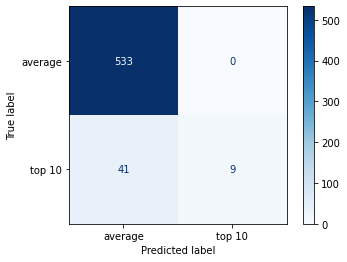

[(0.26043697591157783, 'song_popularity'),
 (0.06131050478708309, 'danceability'),
 (0.058914022657943516, 'artist followers'),
 (0.057226726879785854, 'valence'),
 (0.05542446651819906, 'speechiness'),
 (0.05075394892349924, 'artist popularity'),
 (0.05033243029694795, 'duration_ms'),
 (0.049307455193965705, 'tempo'),
 (0.04908024190883593, 'liveness'),
 (0.048970702350792254, 'loudness'),
 (0.04867062035855604, 'energy'),
 (0.047442112887770345, 'acousticness'),
 (0.03658598993163994, 'artist_id'),
 (0.029832357449533334, 'key'),
 (0.028741609112802453, 'instrumentalness'),
 (0.009432812576633389, 'pop'),
 (0.008535555720984717, 'mode'),
 (0.007166888097521247, 'rnb'),
 (0.006510554373578296, 'rap'),
 (0.005814362211112137, 'hiphop'),
 (0.0056232166722539655, 'mellow'),
 (0.005534609840718886, 'explicit'),
 (0.0053881333369363614, 'rock'),
 (0.004923111844027534, 'edm'),
 (0.003492479605450314, 'time_signature'),
 (0.0027202592740543613, 'country'),
 (0.0018278512777962926, 'latin')]

In [131]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

#train model
rf = rf.fit(X_train, y_train)

#test model
print(f"Training Data Score: {rf.score(X_train, y_train)}")
print(f"Testing Data Score: {rf.score(X_test, y_test)}\n")

predictions = rf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

feature_names = X.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

### KNN

In [30]:
# # PART 1

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScaler model and fit it to the training data
# X_scaler = StandardScaler().fit(X_train)

# # Transform the training and testing data using the X_scaler and y_scaler models
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

# # Loop through different k values to see which has the highest accuracy
# train_scores = []
# test_scores = []
# for k in range(1, 20, 2):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train_scaled, y_train)
#     train_score = knn.score(X_train_scaled, y_train)
#     test_score = knn.score(X_test_scaled, y_test)
#     train_scores.append(train_score)
#     test_scores.append(test_score)
#     print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
# plt.plot(range(1, 20, 2), train_scores, marker='o')
# plt.plot(range(1, 20, 2), test_scores, marker="x")
# plt.xlabel("k neighbors")
# plt.ylabel("Testing accuracy Score")
# plt.show()

In [29]:
# # PART 2

# # Note that k: 5 seems to be the best choice for this dataset
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled, y_train)

# #test model
# print(f"Training Data Score: {knn.score(X_train_scaled, y_train)}")
# print(f"Testing Data Score: {knn.score(X_test_scaled, y_test)}\n")

# predictions = knn.predict(X_test)
# print(classification_report(y_test, predictions,
#                             target_names=target_names))

# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
# plt.show()

# feature_names = X.columns
# sorted(zip(rf.feature_importances_, feature_names), reverse=True)

## SVM

In [132]:
FULL_df.columns

Index(['song_id', 'song_name', 'song_popularity', 'explicit', 'artist_id',
       'artist', 'artist popularity', 'artist followers', 'genre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'top_10', 'pop', 'rap', 'hiphop', 'rock', 'rnb',
       'country', 'mellow', 'edm', 'latin'],
      dtype='object')

Training Data Score: 0.5105895821408128
Testing Data Score: 0.5351629502572899

              precision    recall  f1-score   support

    negative       0.97      0.50      0.67       533
    positive       0.14      0.86      0.24        50

    accuracy                           0.54       583
   macro avg       0.56      0.68      0.45       583
weighted avg       0.90      0.54      0.63       583



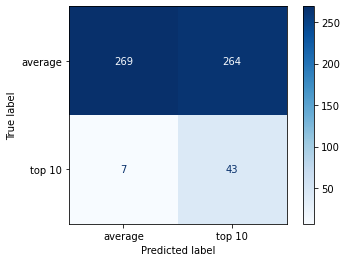

In [134]:
from sklearn.svm import SVC 

model = SVC(kernel='linear', class_weight='balanced')

### Just so that this thing can run...
X_prime = X.drop(['artist popularity', 'artist followers', 
                  'pop', 'rap', 'hiphop', 'rock', 'rnb', 'country', 'mellow', 'edm', 'latin'], axis=1)
X_prime_train, X_prime_test, y_train, y_test = train_test_split(X_prime, y, random_state=rs, stratify=y)

#train model
model.fit(X_prime_train, y_train)

#test model
print(f"Training Data Score: {model.score(X_prime_train, y_train)}")
print(f"Testing Data Score: {model.score(X_prime_test, y_test)}\n")

# Calculate classification report
target_names = ["negative", "positive"]

predictions = model.predict(X_prime_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(model, X_prime_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

## Grid Search

In [ ]:
# #Gridsearch

# # Create the GridSearch estimator along with a parameter object containing the values to adjust
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [1, 5, 10],
#               'gamma': [0.0001, 0.001, 0.01]}
# grid = GridSearchCV(model, param_grid, verbose=3)

# # Fit the model using the grid search estimator. 
# # This will take the SVC model and try each combination of parameters
# grid.fit(X_train, y_train)

# # List the best parameters for this dataset
# print(grid.best_params_)

# # List the best score
# print(grid.best_score_)

# # Make predictions with the hypertuned model
# predictions = grid.predict(X_test)

# # Calculate classification report
# from sklearn.metrics import classification_report
# print(classification_report(y_test, predictions,
#                             target_names=target_names))

---
# PART II - Artist Classification

In [177]:
# New Playlist ID
ARTISTS_PLAYLIST_ID = "42KmFBMaGy21Arc9KzOIL2"

# First we have to gather the total number of tracks in the playlist 
track_count = sp.user_playlist_tracks(USER_ID, ARTISTS_PLAYLIST_ID, 'total')['total']

# Then we calculate the number of times we'll have to call the API
iterations = math.ceil(track_count/100)

# Finally we begin our loop
attributes_df = pd.DataFrame()
information_df = pd.DataFrame()
for i in range(iterations):
    print(f"Compiling songs {(i)*100+1} through {(i+1)*100} of {track_count}")
    playlist = sp.user_playlist_tracks(USER_ID, ARTISTS_PLAYLIST_ID, None, None, i*100) # documentation - https://spotipy.readthedocs.io/en/2.13.0/
    songs = playlist["items"]
    time.sleep(5) # incase this is necessary on larger playlists

    track_ids = []
    track_names = []
    track_popularities = []
    track_explicit = []
    artist_ids = []
    artist_names = []
    artist_popularities = []
    artist_followers = []
    artist_genres = []
    
    for j in range(len(songs)): 
        track_ids.append(songs[j]["track"]["id"])
        track_names.append(songs[j]["track"]["name"])
        track_popularities.append(songs[j]["track"]["popularity"])
        track_explicit.append(songs[j]["track"]["explicit"])
        artist_names.append(songs[j]["track"]["artists"][0]["name"])
        
        artist_id = songs[j]["track"]["artists"][0]["id"]
        artist_ids.append(artist_id)
        artist = sp.artist(artist_id)
        artist_popularities.append(artist['popularity'])
        artist_followers.append(artist['followers']['total'])
        artist_genres.append(artist['genres'])

        
    features = sp.audio_features(track_ids)
    att_df = pd.DataFrame(features)
    info_df = pd.DataFrame({"song_id":track_ids, 
                            "song_name":track_names, 
                            "song_popularity":track_popularities,
                            "explicit":track_explicit,
                            "artist_id":artist_ids, 
                            "artist": artist_names, 
                            "artist popularity": artist_popularities,
                            "artist followers": artist_followers,
                            "genre": artist_genres})
    
    attributes_df = attributes_df.append(att_df, ignore_index=True)
    information_df = information_df.append(info_df, ignore_index=True)

ARTISTS_df = information_df.merge(attributes_df, left_on="song_id", right_on="id")
ARTISTS_df = ARTISTS_df.drop_duplicates(['song_id'])
ARTISTS_df.reset_index(inplace=True, drop=True)
print("-"*40,"\nComplete")
# ARTISTS_df

Compiling songs 1 through 100 of 1281
Compiling songs 101 through 200 of 1281
Compiling songs 201 through 300 of 1281
Compiling songs 301 through 400 of 1281
Compiling songs 401 through 500 of 1281
Compiling songs 501 through 600 of 1281
Compiling songs 601 through 700 of 1281
Compiling songs 701 through 800 of 1281
Compiling songs 801 through 900 of 1281
Compiling songs 901 through 1000 of 1281
Compiling songs 1001 through 1100 of 1281
Compiling songs 1101 through 1200 of 1281
Compiling songs 1201 through 1300 of 1281
---------------------------------------- 
Complete


In [70]:
ARTISTS_df['artist'].value_counts()

Drake            164
Lady Gaga         95
The Weeknd        95
J Balvin          94
DaBaby            82
Justin Bieber     78
Maroon 5          76
Ariana Grande     67
Nicki Minaj       62
Juice WRLD        61
Ozuna             54
Ed Sheeran        54
Post Malone       53
Halsey            48
Travis Scott      46
Khalid            39
Dua Lipa          31
Marshmello        31
Harry Styles      22
Future            16
Fuego              2
Silk City          1
Skrillex           1
Jessie J           1
Adam Levine        1
Omar LinX          1
Young Thug         1
will.i.am          1
Martin Garrix      1
MIKA               1
Sean Paul          1
Calvin Harris      1
Name: artist, dtype: int64

In [71]:
ARTISTS_df[ARTISTS_df.artist=='Future']

,song_id,song_name,song_popularity,explicit,artist_id,artist,artist popularity,artist followers,genre,danceability,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
159,5fHrHoJKfCgBd35zwIBmUK,D4L,75,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.718,...,0.3520,0.815,170.004,audio_features,5fHrHoJKfCgBd35zwIBmUK,spotify:track:5fHrHoJKfCgBd35zwIBmUK,https://api.spotify.com/v1/tracks/5fHrHoJKfCgB...,https://api.spotify.com/v1/audio-analysis/5fHr...,189176,4
1243,2OsDoAzo5SGq10qwmKSQBv,Jet Lag (feat. Young Scooter),65,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.810,...,0.1740,0.493,125.049,audio_features,2OsDoAzo5SGq10qwmKSQBv,spotify:track:2OsDoAzo5SGq10qwmKSQBv,https://api.spotify.com/v1/tracks/2OsDoAzo5SGq...,https://api.spotify.com/v1/audio-analysis/2OsD...,271067,4
1244,2vs5ubqg8QUbfyWZpMfvWe,Astronauts,64,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.732,...,0.1210,0.730,76.480,audio_features,2vs5ubqg8QUbfyWZpMfvWe,spotify:track:2vs5ubqg8QUbfyWZpMfvWe,https://api.spotify.com/v1/tracks/2vs5ubqg8QUb...,https://api.spotify.com/v1/audio-analysis/2vs5...,169920,4
1245,5274I4mUMnYczyeXkGDWZN,Fine China,77,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.656,...,0.1260,0.551,166.111,audio_features,5274I4mUMnYczyeXkGDWZN,spotify:track:5274I4mUMnYczyeXkGDWZN,https://api.spotify.com/v1/tracks/5274I4mUMnYc...,https://api.spotify.com/v1/audio-analysis/5274...,141587,4
1246,3fFBZvG777xoKyvcrBq7lc,Red Bentley (feat. Young Thug),60,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.903,...,0.1790,0.268,149.991,audio_features,3fFBZvG777xoKyvcrBq7lc,spotify:track:3fFBZvG777xoKyvcrBq7lc,https://api.spotify.com/v1/tracks/3fFBZvG777xo...,https://api.spotify.com/v1/audio-analysis/3fFB...,207867,4
1248,0nWMTq3fBceV1uZlhFn6of,Oxy (feat. Lil Wayne),60,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.811,...,0.1300,0.248,149.954,audio_features,0nWMTq3fBceV1uZlhFn6of,spotify:track:0nWMTq3fBceV1uZlhFn6of,https://api.spotify.com/v1/tracks/0nWMTq3fBceV...,https://api.spotify.com/v1/audio-analysis/0nWM...,180080,4
1249,1hHe7cirScEJWgAS0JFqTL,7 Am Freestyle,63,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.951,...,0.1490,0.539,129.976,audio_features,1hHe7cirScEJWgAS0JFqTL,spotify:track:1hHe7cirScEJWgAS0JFqTL,https://api.spotify.com/v1/tracks/1hHe7cirScEJ...,https://api.spotify.com/v1/audio-analysis/1hHe...,192907,4
1250,3thLnNvO9IctWoccbsZyJV,Different (feat. Yung Bans),60,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.456,...,0.1150,0.684,77.058,audio_features,3thLnNvO9IctWoccbsZyJV,spotify:track:3thLnNvO9IctWoccbsZyJV,https://api.spotify.com/v1/tracks/3thLnNvO9Ict...,https://api.spotify.com/v1/audio-analysis/3thL...,151013,4
1251,5ExHDzOoOhC4xZGPh9zyQZ,Shorty,62,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.795,...,0.0973,0.619,131.971,audio_features,5ExHDzOoOhC4xZGPh9zyQZ,spotify:track:5ExHDzOoOhC4xZGPh9zyQZ,https://api.spotify.com/v1/tracks/5ExHDzOoOhC4...,https://api.spotify.com/v1/audio-analysis/5ExH...,121000,4
1252,4VMiNOpnjRwSCwmHaUfOMM,Realer N Realer,66,True,1RyvyyTE3xzB2ZywiAwp0i,Future,91,8945489,"[atl hip hop, pop rap, rap, southern hip hop, ...",0.730,...,0.2800,0.367,148.028,audio_features,4VMiNOpnjRwSCwmHaUfOMM,spotify:track:4VMiNOpnjRwSCwmHaUfOMM,https://api.spotify.com/v1/tracks/4VMiNOpnjRwS...,https://api.spotify.com/v1/audio-analysis/4VMi...,170920,4


In [206]:
### Make this better ###
fav_artist = input("Who is your favorite artist?  ")
print(f"Ok, let's see how predictible {fav_artist} is...")

Who is your favorite artist?  Marshmello
Ok, let's see how predictible Marshmello is...


In [207]:
ARTISTS_df['chosen'] = np.where(ARTISTS_df.artist == fav_artist, 1, 0)
# ARTISTS_df

In [208]:
#Adding columns for the most common genres

pop = [0]*len(ARTISTS_df.index)
rap = [0]*len(ARTISTS_df.index)
rnb = [0]*len(ARTISTS_df.index)
edm = [0]*len(ARTISTS_df.index)
rock = [0]*len(ARTISTS_df.index)
latin = [0]*len(ARTISTS_df.index)
hiphop = [0]*len(ARTISTS_df.index)
mellow = [0]*len(ARTISTS_df.index)
country = [0]*len(ARTISTS_df.index)


for i in range(len(ARTISTS_df["genre"])):
    for item in ARTISTS_df["genre"][i]:

        if (("edm" in item) or 
            ("dance" in item) or 
            ("vapor" in item) or 
            ("techno" in item) or 
            ("electro" in item) or 
            ("brostep" in item) or 
            ("complextro" in item))\
        and (("dancehall" not in item) and
             ("dance pop" not in item)):
            edm[i]=1
            
        if (("rock" in item) or 
            ("punk" in item) or
            ("metal" in item) or
            ("indie" in item) or
            ("grunge" in item) or
            ("baroque" in item) or
            ("permanent wave" in item)):
            rock[i]=1

        if ("pop" in item)\
        and (("punk" not in item) and 
             ("rock" not in item) and 
             ("baroque" not in item) and 
             ("dance pop" not in item) and 
             ("indie poptimism" not in item)):
            pop[i]=1
            
        if (("hip" in item) or 
            ("hop" in item) or 
            ("dancehall" in item) or 
            ("new jack swing" in item)):
            hiphop[i]=1
            
        if (("r&b"in item) or
            ("soul"in item) or
            ("motown"in item) or
            ("quiet storm" in item)):
            rnb[i]=1

        if (("rap" in item) or 
            ("urban" in item))\
        and ("vapor" not in item):
            rap[i]=1
            
        if (("country"in item) or
            ("lilith" in item)):
            country[i]=1

        if "mellow" in item:
            mellow[i]=1
            
        if "latin" in item:
            latin[i]=1

# In order of most appearing (done in excel)   
ARTISTS_df["pop"] = pop
ARTISTS_df["rap"] = rap
ARTISTS_df["hiphop"] = hiphop
ARTISTS_df["rock"] = rock
ARTISTS_df["rnb"] = rnb
ARTISTS_df["country"] = country
ARTISTS_df["mellow"] = mellow
ARTISTS_df["edm"] = edm
ARTISTS_df["latin"] = latin

# ARTISTS_df

In [209]:
# Encode Strings in "Artist Column"
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
ARTISTS_df['song_encoded'] = encode.fit_transform(ARTISTS_df['song_id'])
ARTISTS_df.head(3)

,song_id,song_name,song_popularity,explicit,artist_id,artist,artist popularity,artist followers,genre,danceability,...,pop,rap,hiphop,rock,rnb,country,mellow,edm,latin,song_encoded
0,4pUUhsc8fmZqnsPaOSU5CP,Fireworks,49,True,3TVXtAsR1Inumwj472S9r4,Drake,98,48075925,"[canadian hip hop, canadian pop, hip hop, pop ...",0.560,...,1,1,1,0,0,0,0,0,0,796
1,3bnVNMCk5FJulcpS7aXJbY,Karaoke,44,False,3TVXtAsR1Inumwj472S9r4,Drake,98,48075925,"[canadian hip hop, canadian pop, hip hop, pop ...",0.756,...,1,1,1,0,0,0,0,0,0,616
2,31FWGQxshq14SCZvvyHae1,The Resistance,45,True,3TVXtAsR1Inumwj472S9r4,Drake,98,48075925,"[canadian hip hop, canadian pop, hip hop, pop ...",0.439,...,1,1,1,0,0,0,0,0,0,516


In [210]:
#Set up data

# Assign X (data) and y (target)
X = ARTISTS_df.drop(['song_id', 'song_name',
                     'artist_id', 'artist', 'artist popularity', 'artist followers', 'genre', 
                     'type', 'id', 'uri', 'track_href', 'analysis_url', 
                     'chosen'], axis=1)

y = ARTISTS_df['chosen']
print(X.shape, y.shape)

# Select random state for Notebook
rs = 42

#Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, stratify=y)

(1281, 25) (1281,)


## Decision Tree

Training Data Score: 1.0
Testing Data Score: 1.0

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       313
    positive       1.00      1.00      1.00         8

    accuracy                           1.00       321
   macro avg       1.00      1.00      1.00       321
weighted avg       1.00      1.00      1.00       321



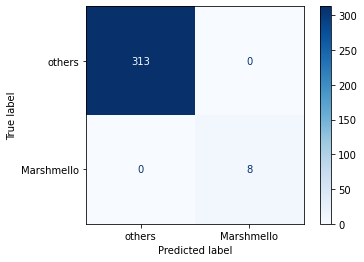

[(0.9220512820512872, 'edm'),
 (0.07156573922530872, 'rock'),
 (0.006382978723404145, 'song_popularity'),
 (0.0, 'valence'),
 (0.0, 'time_signature'),
 (0.0, 'tempo'),
 (0.0, 'speechiness'),
 (0.0, 'song_encoded'),
 (0.0, 'rnb'),
 (0.0, 'rap'),
 (0.0, 'pop'),
 (0.0, 'mode'),
 (0.0, 'mellow'),
 (0.0, 'loudness'),
 (0.0, 'liveness'),
 (0.0, 'latin'),
 (0.0, 'key'),
 (0.0, 'instrumentalness'),
 (0.0, 'hiphop'),
 (0.0, 'explicit'),
 (0.0, 'energy'),
 (0.0, 'duration_ms'),
 (0.0, 'danceability'),
 (0.0, 'country'),
 (0.0, 'acousticness')]

In [211]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight = 'balanced')

#train model
clf = clf.fit(X_train, y_train)

#test model
print(f"Training Data Score: {clf.score(X_train, y_train)}")
print(f"Testing Data Score: {clf.score(X_test, y_test)}\n")

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["others", str(fav_artist)])
plt.show()

feature_names = X.columns
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

In [204]:
Results_df = pd.DataFrame({"prediction": predictions, "actual": y_test, "song_encoded": X_test['song_encoded']}).reset_index(drop=True)
False_Positives_df = Results_df.loc[((Results_df.prediction==1) & (Results_df.actual==0)),:]

In [205]:
False_Positives_df.merge(ARTISTS_df, on='song_encoded')[['song_name', 'artist']]

,song_name,artist
0,WRLD On Drugs,Future
1,Hard Work Pays Off,Future
2,Ain't Livin Right (feat. Gunna),Future
3,Afterlife,Future
4,Realer N Realer,Future
5,Only,Nicki Minaj
6,Red Bentley (feat. Young Thug),Future
